In [1]:
import torch
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.3.0
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [ ]:
# Set the device
#device = "mps" if torch.backends.mps.is_available() else "cpu"


In [2]:
import pandas as pd
import os
from glob import glob
import numpy as np


In [3]:
def get_audio_files(data_dir):
    file_names = []
    file_paths = []

    # Walk through all directories and subdirectories
    for root, dirs, files in os.walk(data_dir):
        # Use glob to find all .wav files in the current directory
        for fp in sorted(glob(os.path.join(root, '*.wav'))):
            bn = os.path.basename(fp)
            file_names.append(bn)
            file_paths.append(fp)

    # Create a DataFrame from the collected file names and paths
    df = pd.DataFrame({
        "filename": file_names,
        "filepath": file_paths,
    })
    return df


In [4]:
# Define the root directory containing all subfolders of interest
data_dir = "../garden_test"
df = get_audio_files(data_dir)
print(df.shape)


(235, 2)


In [5]:
df.head()

,filename,filepath
0,er_file_2023_10_19_10_14_49.wav,../garden_test/161/er_file_2023_10_19_10_14_49...
1,er_file_2023_10_19_10_15_33.wav,../garden_test/161/er_file_2023_10_19_10_15_33...
2,er_file_2023_10_19_10_15_37.wav,../garden_test/161/er_file_2023_10_19_10_15_37...
3,er_file_2023_10_19_10_15_40.wav,../garden_test/161/er_file_2023_10_19_10_15_40...
4,er_file_2023_10_19_10_15_43.wav,../garden_test/161/er_file_2023_10_19_10_15_43...


In [6]:
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [7]:
class Vox(Dataset):
    def __init__(self, dataset_dataframe, audio_sr):
        """ Dataset for vocalization classification with AVES

        Input
        -----
        dataset_dataframe (pandas dataframe): indicating the filepath, annotations and partition of a signal
        audio_sr (int): sampling rate expected by network
        annotation_name (list[str]): string corresponding to the annotation columns in the dataframe, e.g. ["call_type","recording_date"]
        """
        super().__init__()
        self.audio_sr = audio_sr
        #self.annotation_names = annotation_names
        self.dataset_info = dataset_dataframe

    def __len__(self):
        return len(self.dataset_info)

    def get_one_item(self, idx):
      """ Load base audio """
      row = self.dataset_info.iloc[idx]
      x, sr = torchaudio.load(row["filepath"])
      if len(x.size()) == 2:
          x = x[0, :]
      if sr != self.audio_sr:
          x = torchaudio.functional.resample(x, sr, self.audio_sr)
      return x, row

    def __getitem__(self, idx):
        x, row = self.get_one_item(idx)
        out = {"x" : x, "filepath" : row['filepath'], "filename" : row['filename']}
        # no annotations for now
        #for k in self.annotation_names:
        #  out[k] = row[k]
        return out

def get_dataloader(dataset_dataframe, audio_sr):
    return DataLoader(
            Vox(dataset_dataframe, audio_sr),
            batch_size=1,
            shuffle=False,
            drop_last=False
        )

In [8]:
from torchaudio.models import wav2vec2_model
import json
import torch.nn as nn

In [9]:
class AvesMeanEmbedding(nn.Module):
    """ Uses AVES Hubert to embed sounds and classify """
    def __init__(self, config_path, model_path, embedding_dim=768):
        super().__init__()
        # reference: https://pytorch.org/audio/stable/_modules/torchaudio/models/wav2vec2/utils/import_fairseq.html
        self.config = self.load_config(config_path)
        self.model = wav2vec2_model(**self.config, aux_num_out=None)
        self.model.load_state_dict(torch.load(model_path))
        self.audio_sr = 16000

    def load_config(self, config_path):
        with open(config_path, 'r') as ff:
            obj = json.load(ff)
        return obj

    def forward(self, sig):
        """
        Input
          sig (Tensor): (batch, time)
        Returns
          mean_embedding (Tensor): (batch, output_dim)
          logits (Tensor): (batch, n_classes)
        """
        # extract_feature in the sorchaudio version will output all 12 layers' output, -1 to select the final one
        out = self.model.extract_features(sig)[0][-1]
        mean_embedding = out.mean(dim=1) #over time
        return mean_embedding

In [10]:
import sklearn.cluster
from tqdm import tqdm
import matplotlib.pyplot as plt

In [11]:
def run(dataset_dataframe,n_clusters, aves_sr=16000):

  print("~~ Setting up model")
  embedding_model = AvesMeanEmbedding(
      config_path="/Users/evgenynazarenko/DACS_3_year/Thesis/AVES_bio/config.json",
      model_path="/Users/evgenynazarenko/DACS_3_year/Thesis/AVES_bio/aves-base-bio.torchaudio.pt"
  );
  embedding_model.eval()
# Determine the device to use: MPS if available, otherwise CPU
  device = "mps" if torch.backends.mps.is_available() else "cpu"
  embedding_model.to(device)

  print("~~ Setting up dataloader")
  dataloader = get_dataloader(dataset_dataframe, embedding_model.audio_sr)

  print(f"~~ Compute AVES embeddings")
  with torch.no_grad():
    features = []; filepaths = []; filenames = []# ; known_classes = {k:[] for k in annotation_names} no annotations for now
    for data_idx, data_dict in enumerate(tqdm(dataloader)):
        x = data_dict["x"].to(device)# move data to device
        features.append(embedding_model(x).cpu().numpy())
        filepaths.append(data_dict["filepath"])
        filenames.append(data_dict["filename"])
        #no annotations for now
        #for k in annotation_names:
        #  known_classes[k].append(data_dict[k])

  print(f"~~ Begin clustering ")
  X = np.concatenate(features, axis=0) #(n_samples, n_features)
  cluster_method = sklearn.cluster.KMeans(
    n_clusters=n_clusters,
    init='k-means++',
    n_init='auto',
    random_state=0
    )
  predictions = cluster_method.fit_predict(X)

  return {
        "filepaths": filepaths,
        "filenames": filenames,
        "predictions": predictions
    }


In [27]:
test_file_path = '../garden_test/160/er_file_2023_10_19_9_38_24.wav'
waveform, sample_rate = torchaudio.load(test_file_path)
print(waveform, sample_rate)


tensor([[ 0.0023,  0.0022,  0.0022,  ..., -0.0010, -0.0012, -0.0007],
        [ 0.0012,  0.0013,  0.0011,  ...,  0.0009,  0.0011,  0.0007]]) 48000


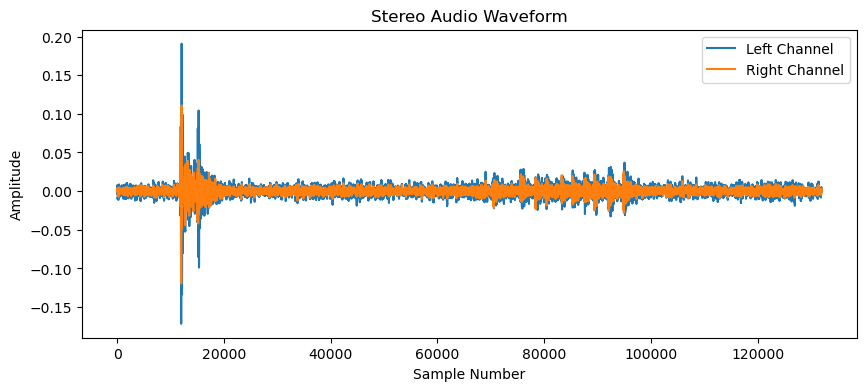

In [17]:
import matplotlib.pyplot as plt

# Assuming `waveform` is your tensor and has shape [2, N] where N is the number of samples
plt.figure(figsize=(10, 4))
plt.plot(waveform.t().numpy())  # Transpose to [N, 2] and convert to numpy for plotting
plt.title("Stereo Audio Waveform")
plt.ylabel("Amplitude")
plt.xlabel("Sample Number")
plt.legend(['Left Channel', 'Right Channel'])
plt.show()


In [15]:
# Run the clustering

n_clusters = 5
results = run(df, n_clusters)
print(f"Clustering results: {results}")


~~ Setting up model
~~ Setting up dataloader
~~ Compute AVES embeddings


100%|██████████| 235/235 [00:12<00:00, 18.78it/s]

~~ Begin clustering 
Clustering results: {'filepaths': [['../garden_test/161/er_file_2023_10_19_10_14_49.wav'], ['../garden_test/161/er_file_2023_10_19_10_15_33.wav'], ['../garden_test/161/er_file_2023_10_19_10_15_37.wav'], ['../garden_test/161/er_file_2023_10_19_10_15_40.wav'], ['../garden_test/161/er_file_2023_10_19_10_15_43.wav'], ['../garden_test/161/er_file_2023_10_19_10_17_19.wav'], ['../garden_test/161/er_file_2023_10_19_10_20_37.wav'], ['../garden_test/161/er_file_2023_10_19_10_22_30.wav'], ['../garden_test/161/er_file_2023_10_19_10_22_33.wav'], ['../garden_test/161/er_file_2023_10_19_10_23_33.wav'], ['../garden_test/161/er_file_2023_10_19_10_24_49.wav'], ['../garden_test/161/er_file_2023_10_19_10_25_52.wav'], ['../garden_test/161/er_file_2023_10_19_10_25_56.wav'], ['../garden_test/161/er_file_2023_10_19_10_26_02.wav'], ['../garden_test/161/er_file_2023_10_19_10_28_24.wav'], ['../garden_test/161/er_file_2023_10_19_10_28_28.wav'], ['../garden_test/161/er_file_2023_10_19_10_28_37

In [20]:
results_df = pd.DataFrame(results)
results_df['predictions'].value_counts()

predictions
0    92
3    65
4    43
2    20
1    15
Name: count, dtype: int64

Ok, now let's get the labeld data with BirdNET and filter (Streptopelia decaocto_Eurasian Collared-Dove 3819) and
(Columba palumbus_Common Wood-Pigeon 3182) detections
 

In [22]:
# read the file from metadata folder
metedata = pd.read_csv('../MIT_AST/metadata/stats_full_25.04_full.csv')
metedata.head()

,datetime,precipRate,pressureMax,dewptAvg,windgustHigh,windspeedAvg,tempAve,humidityAvg,winddirAvg,uvHigh,solarRadiationHigh,BirdNET,MIT_AST_label,sound_class_label
0,2024-03-03 08:34:48,0.0,995.33,7.6,3.5,1.4,9.6,88.0,286.0,0.0,36.0,NaN,Bird,bird
1,2024-03-03 08:34:50,0.0,995.33,7.6,3.5,1.4,9.6,88.0,286.0,0.0,36.0,Streptopelia decaocto_Eurasian Collared-Dove,Owl,bird
2,2024-03-03 08:34:53,0.0,995.33,7.6,3.5,1.4,9.6,88.0,286.0,0.0,36.0,Streptopelia decaocto_Eurasian Collared-Dove,Owl,bird
3,2024-03-03 08:34:56,0.0,995.33,7.6,3.5,1.4,9.6,88.0,286.0,0.0,36.0,Streptopelia decaocto_Eurasian Collared-Dove,Bird,bird
4,2024-03-03 08:34:59,0.0,995.33,7.6,3.5,1.4,9.6,88.0,286.0,0.0,36.0,NaN,Bird,bird


In [25]:
# filter dove detections
dove_df = metedata[metedata['BirdNET'] == 'Streptopelia decaocto_Eurasian Collared-Dove']
print(dove_df.shape)
dove_df.head()


(3819, 14)


,datetime,precipRate,pressureMax,dewptAvg,windgustHigh,windspeedAvg,tempAve,humidityAvg,winddirAvg,uvHigh,solarRadiationHigh,BirdNET,MIT_AST_label,sound_class_label
1,2024-03-03 08:34:50,0.0,995.33,7.6,3.5,1.4,9.6,88.0,286.0,0.0,36.0,Streptopelia decaocto_Eurasian Collared-Dove,Owl,bird
2,2024-03-03 08:34:53,0.0,995.33,7.6,3.5,1.4,9.6,88.0,286.0,0.0,36.0,Streptopelia decaocto_Eurasian Collared-Dove,Owl,bird
3,2024-03-03 08:34:56,0.0,995.33,7.6,3.5,1.4,9.6,88.0,286.0,0.0,36.0,Streptopelia decaocto_Eurasian Collared-Dove,Bird,bird
5,2024-03-03 08:35:02,0.0,995.33,7.6,3.5,1.4,9.6,88.0,286.0,0.0,36.0,Streptopelia decaocto_Eurasian Collared-Dove,Hoot,bird
7,2024-03-03 08:35:08,0.0,995.33,7.6,3.5,1.4,9.6,88.0,286.0,0.0,36.0,Streptopelia decaocto_Eurasian Collared-Dove,Hoot,bird


In [34]:
str = dove_df['datetime'].iloc[0]

In [39]:
from datetime import datetime

def format_datetime_for_filename(datetime_str):
    """
    Converts a datetime string into a format suitable for filenames.
    
    Args:
    datetime_str (str): The datetime string in the format 'YYYY-MM-DD HH:MM:SS'.
    
    Returns:
    str: A string suitable for use in a filename.
    """
    return datetime_str.replace(':', '_').replace(' ', '_').replace('-', '_')



In [40]:
format_datetime_for_filename(str)

'2024_03_03_08_34_50'

In [42]:
from datetime import datetime

def generate_file_name(date_time_str, file_prefix='er_file_'):
    """
    Generate a file path for an audio file based on the date and time.

    Parameters:
    - date_time_str (str): The date and time string in the format 'YYYY-MM-DD HH:MM:SS'.
    
    - file_prefix (str): Prefix for the filename.

    Returns:
    - str: The full path to the file.
    """
    # Convert the date_time_str to a datetime object
    date_time_obj = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')
    
    # Format the datetime object into the filename format 'YYYY_MM_DD_H_MM_SS'
    file_name = date_time_obj.strftime('%Y_%m_%d_%H_%M_%S')
    
    # Append file extension
    file_extension = '.wav'
    
    # Construct the full file path
    full_file_name = f"{file_prefix}{file_name}{file_extension}"
    
    return full_file_name

# Example usage

test_file_path = generate_file_name(str)
print("Generated File Path:", test_file_path)


Generated File Path: er_file_2024_03_03_08_34_50.wav


In [43]:
# reconstruct the file path from datetime column and add it to the dataframe
# Applying the function to create file paths using .loc and column names directly
dove_df.loc[:, 'file_path'] = dove_df['datetime'].apply(generate_file_name)
dove_df.head()

/var/folders/lh/0lt7mv811l56hczm0y7dwzym0000gn/T/ipykernel_37232/1048065166.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dove_df['file_path'] = dove_df['datetime'].apply(lambda x: generate_file_name(x))


,datetime,precipRate,pressureMax,dewptAvg,windgustHigh,windspeedAvg,tempAve,humidityAvg,winddirAvg,uvHigh,solarRadiationHigh,BirdNET,MIT_AST_label,sound_class_label,file_path
1,2024-03-03 08:34:50,0.0,995.33,7.6,3.5,1.4,9.6,88.0,286.0,0.0,36.0,Streptopelia decaocto_Eurasian Collared-Dove,Owl,bird,er_file_2024_03_03_08_34_50.wav
2,2024-03-03 08:34:53,0.0,995.33,7.6,3.5,1.4,9.6,88.0,286.0,0.0,36.0,Streptopelia decaocto_Eurasian Collared-Dove,Owl,bird,er_file_2024_03_03_08_34_53.wav
3,2024-03-03 08:34:56,0.0,995.33,7.6,3.5,1.4,9.6,88.0,286.0,0.0,36.0,Streptopelia decaocto_Eurasian Collared-Dove,Bird,bird,er_file_2024_03_03_08_34_56.wav
5,2024-03-03 08:35:02,0.0,995.33,7.6,3.5,1.4,9.6,88.0,286.0,0.0,36.0,Streptopelia decaocto_Eurasian Collared-Dove,Hoot,bird,er_file_2024_03_03_08_35_02.wav
7,2024-03-03 08:35:08,0.0,995.33,7.6,3.5,1.4,9.6,88.0,286.0,0.0,36.0,Streptopelia decaocto_Eurasian Collared-Dove,Hoot,bird,er_file_2024_03_03_08_35_08.wav
